In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision.transforms import Resize

from tqdm import tqdm
import imageio
import gc

In [2]:
from ResNet import some_model

In [3]:
cfg = dict()
cfg['n_channels'] = 50
cfg['input_channels'] = 1
cfg['output_channels'] = 6
cfg['dropout'] = 0.2
cfg['fc_intermediate_len'] = 100 # ? 128
cfg['x_size'] = 150 # ? such order of dims
cfg['y_size'] = 300 # ? such order of dims

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
def load_pic(image_id, is_train=True):
    _ = 'train' if is_train else 'test'
    directory = 'original_data/{}/{}/{}/{}/'.format(_, image_id[0], image_id[1], image_id[2])
    return torch.Tensor(imageio.imread(directory + image_id + '.png') )

In [6]:
# For multiple target regression
class PretrainRegressionDataset(torch.utils.data.Dataset):
    def __init__(self, file, y_file, x_size=256, y_size=256):
        self.data = pd.read_csv(file)
        
        # choosing atoms C, N, O, F, S, Cl
        y  = np.zeros((self.data.shape[0], cfg['output_channels'])) # output_channels=6
        y[:,:4] = np.load(y_file)[:,1:5]
        y[:,4] = np.load(y_file)[:,7]
        y[:,5] = np.load(y_file)[:,8]
        
        self.y = torch.tensor(y, dtype=torch.float32)#.unsqueeze(1)
        self.y.to(device)
        self.x_size = x_size
        self.y_size = y_size
        self.resize = Resize(size=(x_size,y_size))
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        pic = load_pic(self.data['image_id'][index]).unsqueeze(0) # C=1 channel
        pic = self.resize(pic) / 255.
        y = self.y[index,:]
        return pic, y

In [7]:
dataset_train = PretrainRegressionDataset('data/pretrain2/data_train_small.csv',
                                          'data/pretrain2/atom_counts_train_small.npy',
                                           x_size=cfg['x_size'], y_size=cfg['y_size'])
dataset_test = PretrainRegressionDataset('data/pretrain2/data_test_small.csv',
                                          'data/pretrain2/atom_counts_test_small.npy',
                                          x_size=cfg['x_size'], y_size=cfg['y_size'])

In [8]:
x, y = dataset_train[5]
print(y)
del x
del y

tensor([21.,  9.,  6.,  0.,  1.,  0.])


In [9]:
def calc_loss(cnn, data_loader, loss_type='mse'):
    if loss_type =='mse': 
        Loss = nn.MSELoss()
    elif loss_type == 'mae':
        Loss = nn.L1Loss(reduction='sum')
    else:
        return 'ERROR'

    loss = 0.0
    count = 0
    cnn.eval()
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            predictions = cnn(x_batch)
            loss += Loss(predictions, y_batch).item()
            count += y_batch.shape[0] * y_batch.shape[1]
    return loss / count

In [10]:
def train_epoch(data_loader, cnn, optimizer, criterion):
    running_loss = 0.0
    for x_batch, y_batch in tqdm(data_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = cnn(x_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    return running_loss

In [11]:
def train_model(dataset_train, dataset_test, cnn, n_epochs, batch_size, history):
    data_train_loader = torch.utils.data.DataLoader(dataset_train, batch_size,
                                                   num_workers=10, persistent_workers=True,pin_memory=True)
    data_test_loader  = torch.utils.data.DataLoader(dataset_test, batch_size, num_workers=2,pin_memory=False)

    #criterion = nn.MSELoss()
    #criterion = nn.L1Loss()
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0002)
    for i in range(n_epochs):
        print('Starting epoch {}'.format(i))
        cnn.train()
        train_loss = train_epoch(data_train_loader, cnn, optimizer, criterion)
        
        print('Train running loss (L1Smooth):\t', train_loss)
        train_loss = calc_loss(cnn, data_train_loader, 'mae')
        test_loss  = calc_loss(cnn, data_test_loader,  'mae')
        print('Train loss (MAE):\t', train_loss)
        print('Test  loss (MAE):\t', test_loss)
        history.append((train_loss, test_loss))

In [12]:
resnet = some_model(cfg['output_channels'], channels=1)
resnet.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (i_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, m

In [13]:
gc.collect()
torch.cuda.empty_cache()

In [14]:
history = []

In [15]:
%%time
train_model(dataset_train, dataset_test, resnet, n_epochs=5, batch_size=20, history=history)

  0%|          | 0/400 [00:00<?, ?it/s]

Starting epoch 0


100%|██████████| 400/400 [01:51<00:00,  3.59it/s]


Train running loss (L1Smooth):	 385.91418477892876


  0%|          | 0/400 [00:00<?, ?it/s]

Train loss (MAE):	 1.001234491189321
Test  loss (MAE):	 1.0063851172129312
Starting epoch 1


100%|██████████| 400/400 [01:51<00:00,  3.59it/s]


Train running loss (L1Smooth):	 221.672937810421


  0%|          | 0/400 [00:00<?, ?it/s]

Train loss (MAE):	 1.2850801467895507
Test  loss (MAE):	 1.2755133330027262
Starting epoch 2


100%|██████████| 400/400 [01:51<00:00,  3.60it/s]


Train running loss (L1Smooth):	 178.80909568071365


  0%|          | 0/400 [00:00<?, ?it/s]

Train loss (MAE):	 0.7917481228510539
Test  loss (MAE):	 0.7993912855784099
Starting epoch 3


100%|██████████| 400/400 [01:51<00:00,  3.60it/s]


Train running loss (L1Smooth):	 145.60742515325546


  0%|          | 0/400 [00:00<?, ?it/s]

Train loss (MAE):	 0.6061205196380616
Test  loss (MAE):	 0.6351708749135335
Starting epoch 4


100%|██████████| 400/400 [01:51<00:00,  3.59it/s]


Train running loss (L1Smooth):	 129.3473268300295
Train loss (MAE):	 0.5496132281621298
Test  loss (MAE):	 0.5908297357559205
CPU times: user 9min 55s, sys: 3min 19s, total: 13min 15s
Wall time: 13min 8s


In [16]:
preds = [None] * 10
trues = []
resnet.eval()
for index, (_, __) in enumerate(dataset_test):
    if index > 0:
        break
    print(__)
    with torch.no_grad():
        pred = np.round(resnet(_.unsqueeze(0).to(device)).to(torch.device('cpu')).numpy(), 2)
        print(pred)
    #preds[index] = pred
    #trues.append(__.item())
        
#print(*np.round(preds, 2), sep='\t')
#print(*trues, sep='\t')

tensor([13.,  4.,  3.,  0.,  1.,  0.])
[[12.59  3.72  2.52 -0.05  0.37  0.19]]


In [17]:
torch.save(resnet.state_dict(), 'data/resnet_multiple_v1.model')

## Mostly in the Kaggle notebook

In [1]:
import numpy as np

In [5]:
a = [[5.76697835, 5.77875161],
 [3.66080774, 3.68216743],
 [2.54854342, 2.60028707],
 [2.6220132,  2.67416902],
 [2.16255738, 2.23320235],
 [2.26665866, 2.3315101 ]]
b = [(1.0005799310684205, 1.1503757469177247), 
     (0.979543825340271, 1.1413592300415039), 
     (0.9017130914688111, 1.0895325241088867), 
     (0.8772111429214478, 1.0770070693969727), 
     (0.8613960321426392, 1.073634188079834)]

a_np = np.zeros((len(a)+len(b), 2))
a_np[:len(a),:] = np.array(a)
for i in range(len(b)):
    a_np[len(a)+i,0] = b[i][0]
    a_np[len(a)+i,1] = b[i][1]
a_np

array([[5.76697835, 5.77875161],
       [3.66080774, 3.68216743],
       [2.54854342, 2.60028707],
       [2.6220132 , 2.67416902],
       [2.16255738, 2.23320235],
       [2.26665866, 2.3315101 ],
       [1.00057993, 1.15037575],
       [0.97954383, 1.14135923],
       [0.90171309, 1.08953252],
       [0.87721114, 1.07700707],
       [0.86139603, 1.07363419]])

In [6]:
import matplotlib.pyplot as plt

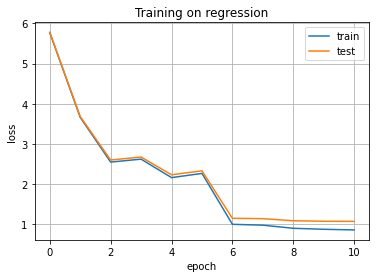

In [8]:
x = np.arange(len(a_np))
plt.plot(x, a_np[:,0])
plt.plot(x, a_np[:,1])
plt.legend(['train', 'test'])
plt.title('Training on regression')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.savefig('data/mult_regr.png')
plt.show()